# Analyzing Football Player Scores

We live in an era where data has become largely available for almost any field of study. And sports is no different. Every action a player makes is measured, and made available through extensive datasets. With all this data available, what could we use it for?\
We will be looking at a set of stats for Football players in Spain and France, two of the world's most important leagues. By segmenting players into clusters, we start by finding groups with similarities. The clusters might resemble the positions, Forward, Midfielder and Defender, but not all players end up in the same cluster as its position. Are some midfielders playing more like a defender? And who are the players that are most different from all the groups?\
The data can also be useful to discover what makes each player unique. Which are the aspects in which a player stands out from the rest?\
Data doesn't replace watching the games to learn about the sport, but it is a great complement. It allows us to let go of biases, and also put into numbers intuitions one might have. Is Messi in 2022 so different from the rest? According to this data, yes, he is the player with a the most different playing style.

![SegmentLocal](Images/messi-psg.jpeg "segment")

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

import matplotlib.pyplot as plt
import plotly.express as px

from requests import get as get
from requests import post as post
import json
import bcrypt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA

## Exploratory Analysis

The data was obtained from Sorare, a Fantasy Football website that provides stats and scores for each player in major leagues through a GraphQL API. After doing some needed transformations it was saved to a csv file.
The detailes of the request to the Sorare api and the following data manipulations can be seen in the sorare-api notebook.

In [3]:
# import csv data
df_player_scores_detailed = pd.read_csv('players_grouped.csv')

df_player_scores_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1327 entries, 0 to 1326
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         1327 non-null   int64  
 1   name                               1327 non-null   object 
 2   slug_club                          1327 non-null   object 
 3   displayName                        1327 non-null   object 
 4   slug_player                        1327 non-null   object 
 5   status.lastFiveSo5Appearances      1327 non-null   int64  
 6   status.lastFiveSo5AverageScore     1327 non-null   float64
 7   status.lastFifteenSo5Appearances   1327 non-null   int64  
 8   status.lastFifteenSo5AverageScore  1327 non-null   float64
 9   status.playingStatus               1327 non-null   object 
 10  position                           1327 non-null   object 
 11  score                              1327 non-null   float

By looking at some variables we gain a better understanding of the data:

- We have 4 types of players: Midfielders, Goalkeepers, Forwards and Defenders
- Many players are not currently playing and should probably be excluded from the analysis as they don't have any stat values. 
- The distribution of stats appear to be skewed. A few players are getting considerably higher values than the rest
- As expected, players in different positions have different values for each stat, with weaknesses and strengths.
- Goalkeepers are the most different, as they are measured by different stats

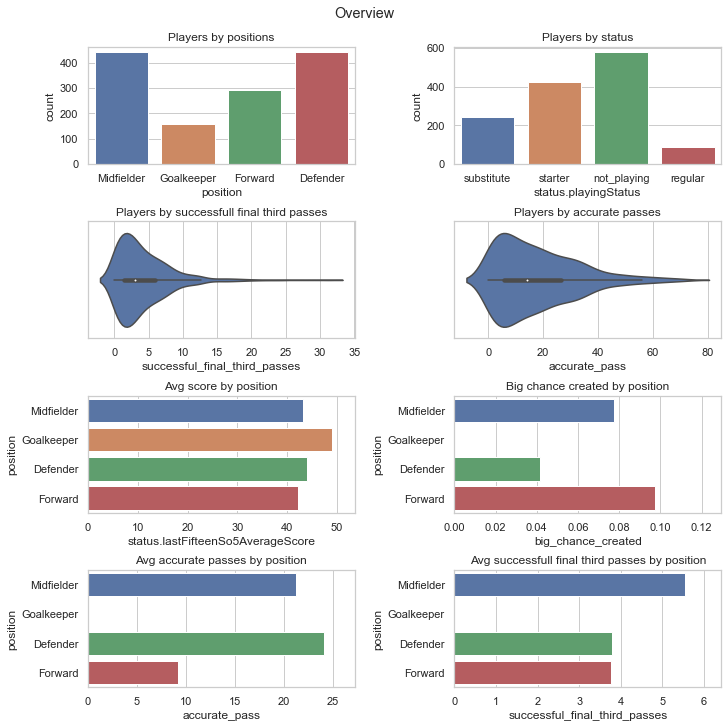

In [33]:
fig, ax = plt.subplots(4,2, figsize=(10,10), constrained_layout=True)
cax = ax[0,0]
sns.countplot(data= df_player_scores_detailed, x='position', ax=cax)
cax.set_title('Players by positions');

cax = ax[0,1]
sns.countplot(data= df_player_scores_detailed, x='status.playingStatus', ax=cax)
cax.set_title('Players by status');

#excluding not playing
cax = ax[1,0]
sns.violinplot(data= df_player_scores_detailed[df_player_scores_detailed['status.playingStatus']!='not_playing'],
 x='successful_final_third_passes', ax=cax)
cax.set_title('Players by successfull final third passes');

cax = ax[1,1]
sns.violinplot(data= df_player_scores_detailed[df_player_scores_detailed['status.playingStatus']!='not_playing'],
 x='accurate_pass', ax=cax)
cax.set_title('Players by accurate passes');

cax = ax[2,0]
sns.barplot(data= df_player_scores_detailed[df_player_scores_detailed['status.playingStatus']!='not_playing'], 
y='position', x='status.lastFifteenSo5AverageScore', 
ax=cax, orient='h',  errwidth=0)
cax.set_title('Avg score by position');

cax = ax[2,1]
sns.barplot(data= df_player_scores_detailed[df_player_scores_detailed['status.playingStatus']!='not_playing'], 
y='position', x='big_chance_created', 
ax=cax, orient='h',  errwidth=0)
cax.set_title('Big chance created by position');

cax = ax[3,0]
sns.barplot(data= df_player_scores_detailed[df_player_scores_detailed['status.playingStatus']!='not_playing'], 
y='position', x='accurate_pass', 
ax=cax, orient='h',  errwidth=0)
cax.set_title('Avg accurate passes by position');

cax = ax[3,1]
sns.barplot(data= df_player_scores_detailed[df_player_scores_detailed['status.playingStatus']!='not_playing'], 
y='position', x='successful_final_third_passes', 
ax=cax, orient='h',  errwidth=0)
cax.set_title('Avg successfull final third passes by position');


plt.suptitle('Overview');

### Understanding Stats

In [36]:
stat_columns=df_player_scores_detailed.columns[13:].tolist()
#stat_columns.remove('level_score')
#stat_columns.remove('score')

### What are the differences between each position?

In order to answer this, we are going to compare the average stats for each position.  

We scale stats with min max scaler so that they are in the same scale and can be compared.

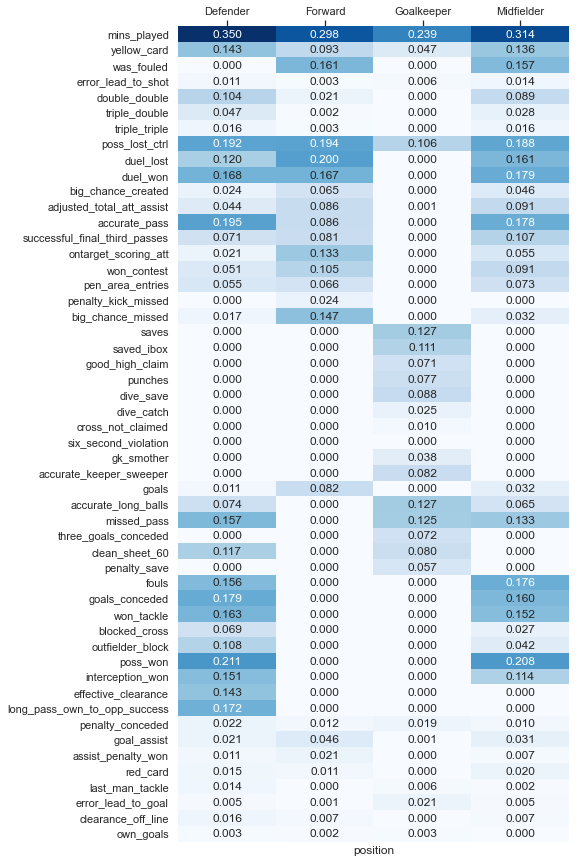

In [37]:
scaler_minmax=MinMaxScaler()
stats_scaled=scaler_minmax.fit_transform(df_player_scores_detailed[stat_columns])

df_stats_minmax=pd.DataFrame(data=stats_scaled,columns=stat_columns)
df_stats_minmax['position']=df_player_scores_detailed['position']

plt.figure(figsize=(7,15))
sns.heatmap(df_stats_minmax.groupby('position')[stat_columns].mean().T,annot=True,cbar=False,fmt='.3f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')


Some takeaways when we look at this are:
- Goalkeepers are measured mostly by their own set of stats (like "saves")
- Midfielders and Defenders share some traits related to passes, possesion and interceptions. But midfielders are also more involved in some offensive stats. 
- Forwards stand out in scoring and assisting (and also missing)

This seems to confirm our intuiton that by looking at the stats we might determine the player's position. 

In the next section we are going to use clustering to classify players, and make an inference about their position. Then we can analyze the differences between the inferred position and the real one, and also detect players which stand out from the rest.

## Clustering

The first step is to filter de dataset. We keep only starter and regular players, and we exclude the Goalkeepers, as they don't share enough characteristics with the other players.

In [298]:
mask_starter=df_player_scores_detailed['status.playingStatus']=='starter'
#mask_regular=df_player_scores_detailed['status.playingStatus']=='regular'
mask_not_goalkeeper=df_player_scores_detailed['position']!='Goalkeeper'
X0=df_player_scores_detailed[(mask_starter )&(mask_not_goalkeeper)]
X=X0[stat_columns]

#
selector = VarianceThreshold()
selector.fit(X)

#display(pd.DataFrame({'feature name': X.columns, 'keep': selector.get_support()}))

print('drop:', [f for f, k in zip(X.columns, selector.get_support()) if k ==False])

X = X.loc[:,selector.get_support()]
print(X.shape)


selector = VarianceThreshold(0.001)
selector.fit(X)

#display(pd.DataFrame({'feature name': X.columns, 'keep': selector.get_support()}))

print('drop:', [f for f, k in zip(X.columns, selector.get_support()) if k ==False])

X = X.loc[:,selector.get_support()]
print(X.shape)




drop: ['saves', 'saved_ibox', 'good_high_claim', 'punches', 'dive_save', 'dive_catch', 'cross_not_claimed', 'six_second_violation', 'gk_smother', 'accurate_keeper_sweeper', 'three_goals_conceded', 'penalty_save']
(381, 40)
drop: ['penalty_kick_missed', 'last_man_tackle', 'clearance_off_line', 'own_goals']
(381, 36)


In [299]:
X0.groupby('status.playingStatus')['mins_played'].describe()

,count,mean,std,min,25%,50%,75%,max
status.playingStatus,,,,,,,,
starter,381.0,71.728084,13.669158,39.8,60.4,72.0,84.8,96.0


### PCA

We still have 52 variables, so we are going to use PCA to reduce that number.

In [300]:
#scale
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)

pca_df = PCA()
pca_df.fit(X_scaled)
pca_df.explained_variance_ratio_.round(2)

array([0.26, 0.13, 0.07, 0.06, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  ])

After creating the components with PCA, we plot the cumulative explained variance, to determine how many components would be useful to keep. 

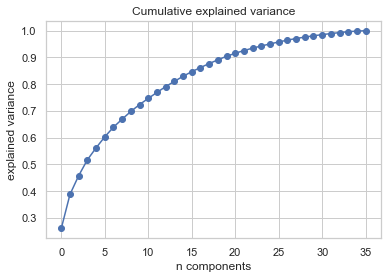

In [301]:
pd.Series(pca_df.explained_variance_ratio_).cumsum().plot.line(marker='o')
plt.title('Cumulative explained variance')
plt.xlabel('n components')
plt.ylabel('explained variance');

And then we overlook which features are more present in each of the first 10 components. We can see that for example:
- Component 3 is mostly yellow cards
- 

In [302]:
pca_loadings = pd.DataFrame(pca_df.components_.T, index=X.columns).iloc[:,:10]
pca_loadings.style.background_gradient(axis=None,cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9
mins_played,-0.179288,0.272834,0.453459,0.268587,0.057811,-0.103829,-0.124907,-0.095699,0.123613,-0.114356
yellow_card,-0.097613,0.061364,-0.524364,0.811831,-0.053196,0.013481,0.038278,-0.020036,0.130234,0.072961
was_fouled,0.200292,0.392757,-0.172120,-0.049118,0.135794,-0.365142,0.041985,0.047878,-0.074360,-0.329404
error_lead_to_shot,-0.011907,-0.024246,-0.028223,0.011491,0.017285,-0.038345,0.005957,-0.038234,0.009652,0.016514
double_double,-0.184051,0.158192,-0.152855,-0.091656,0.465282,0.088016,0.358215,-0.491575,0.039846,0.150096
triple_double,-0.078929,0.043262,0.010742,-0.087253,0.108598,0.106812,-0.154671,0.317720,0.274114,0.278247
triple_triple,-0.024206,0.024251,-0.051662,-0.009377,0.120231,0.015039,0.031870,0.339447,0.405032,-0.371637
poss_lost_ctrl,0.003910,0.302666,0.185279,0.092887,-0.102471,0.378679,-0.050690,-0.101856,-0.028103,-0.028816
duel_lost,0.104937,0.210639,0.066619,0.097603,0.111801,0.062781,-0.182486,0.126195,-0.240420,-0.111040
duel_won,-0.031657,0.306149,0.039757,0.023811,0.367603,0.039406,0.036737,0.098938,-0.151085,-0.217626


### Cluster

In [303]:
def Search_Kmeans(X_scaled):
    k_values=range(2,20)
    sq_distances=[] 
    sil=[]
    ch_scores=[]
    for k in k_values:
        kmeans=KMeans(n_clusters=k,n_init=10,random_state=0)
        kmeans.fit(X_scaled)
        sq_distances.append(kmeans.inertia_)
        score=silhouette_score(X_scaled,kmeans.labels_)
        sil.append(score)
        score=calinski_harabasz_score(X_scaled,kmeans.labels_)
        ch_scores.append(score)

    fig, axs = plt.subplots(1,3,figsize=(20,5))
    axs[0].set(xlabel = "Número de clusters", ylabel = "Suma Distancias Cuadráticas", title = "Inercia Score")
    axs[1].set(xlabel = "Número de clusters", ylabel = "Silhouette score", title = "Silhouette Score")
    axs[2].set(xlabel = "Número de clusters", ylabel = "Calinski-Harabasz Score", title = "Calinski-Harabasz Score")
    sns.lineplot(ax=axs[0],x=k_values,y=sq_distances,marker='o',size=30,legend=False )
    sns.lineplot(ax=axs[1],x=k_values,y=sil,marker='o',size=30,legend=False )
    sns.lineplot(ax=axs[2],x=k_values,y=ch_scores,marker='o',size=30,legend=False )
    axs[0].grid(color='gray', linewidth=1, ls='--')
    axs[1].grid(color='gray', linewidth=1, ls='--')
    axs[2].grid(color='gray', linewidth=1, ls='--')

In [304]:
X.shape

(381, 36)

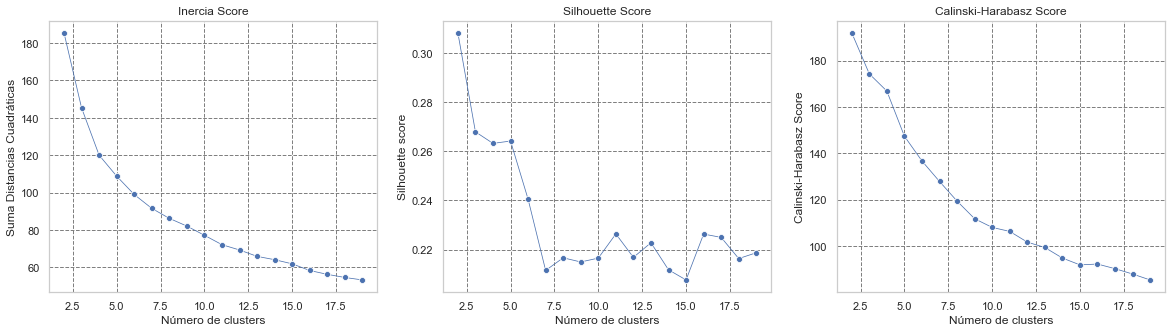

In [318]:
n_components=5
df_pca = pd.DataFrame(pca_df.transform(X_scaled)[:,:n_components], index=X.index)
df_pca.head(5)

Search_Kmeans(df_pca)

Generate 3 clusters, and calculate distance to each centroid

In [319]:
n_clusters=3
kmeans=KMeans(n_clusters=n_clusters,random_state=1)
kmeans.fit(df_pca)

df_output=df_player_scores_detailed.loc[X.index]
df_output['label']=kmeans.labels_

dist_clusters=kmeans.transform(df_pca)
df_dist_clusters=pd.DataFrame(index=df_pca.index,data=dist_clusters)
dist_col_names=['dist_cluster_'+str(i) for i in df_dist_clusters.columns]
df_output[dist_col_names]=df_dist_clusters


### Cluster Analysis

Visualize which positions are included in each cluster

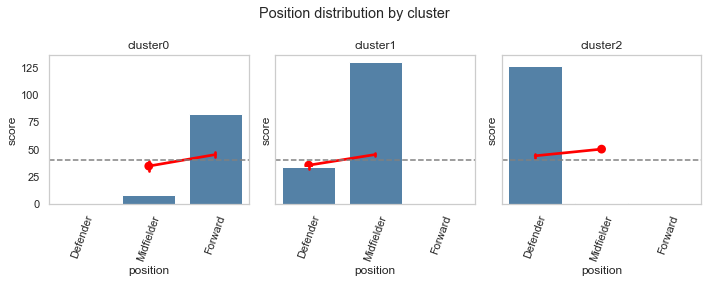

In [320]:

positions=['Defender','Midfielder','Forward']
labels=range(0,n_clusters)

n_plots=df_output['label'].nunique()
max_col=n_clusters
max_row=int(np.ceil(n_plots/max_col))

n_row=0
n_col=0
fig,ax=plt.subplots(max_row,max_col,figsize=(10,4),squeeze=False,sharey=True)
for i in range(n_plots):
    df=df_output[df_output.label==i]
    ax_i=ax[n_row,n_col]
    sns.countplot(data=df,x='position',ax=ax_i,color='steelblue',order=positions)
    sns.pointplot(data=df,x='position',y='score',ax=ax_i,color='red',order=positions)
    ax_i.axhline(40, ls='--',color='gray')
    ax_i.set_xticklabels(ax_i.get_xticklabels(),rotation=70)

    ax_i.set_title('cluster'+str(i))
    ax_i.grid(False)
    n_col+=1
    if(n_col==max_col):
        n_col=0
        n_row+=1
plt.suptitle('Position distribution by cluster')
plt.tight_layout()

The clusters are mainly grouping by position. Something interesting is that there are players that seem to be "misclassified", for example defenders in the cluster with mostly midfielders, or midfielders in the cluster with mostly forwards. We will try to identify if these players have a playing style more similar than those in the other position and why.

Visualize how each position is distributed between clusters

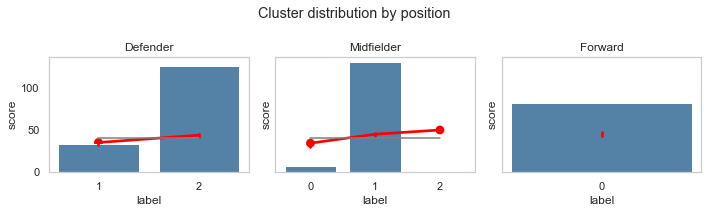

In [321]:
n_plots=df_output['label'].nunique()
max_col=3
max_row=int(np.ceil(len(positions)/max_col))

n_row=0
n_col=0
fig,ax=plt.subplots(max_row,max_col,figsize=(10,3),squeeze=False,sharey=True)
for i in positions:
    df=df_output[df_output.position==i].copy()
    ax_i=ax[n_row,n_col]
    sns.countplot(data=df,x='label',ax=ax_i,color='steelblue',order=labels)
    sns.pointplot(data=df,x='label',y='score',ax=ax_i,color='red',order=labels)
    sns.lineplot(x=df.label,y=np.ones(df.label.shape[0])*40,ax=ax_i,color='gray')

    ax_i.set_title(str(i))
    ax_i.grid(False)
    n_col+=1
    if(n_col==max_col):
        n_col=0
        n_row+=1
plt.suptitle('Cluster distribution by position')
plt.tight_layout()


Give names to each cluster

In [322]:
df_output['label_name']=df_output.label.map({0:'Offensive',1:'Mid',2:'Defensive',3:'c3'})

df_output.rename(columns={
    'dist_cluster_0':'dist_offensive',
    'dist_cluster_1':'dist_midfielder',
    'dist_cluster_2':'dist_defensive',
},inplace=True)

dist_col_names=['dist_midfielder',
    'dist_offensive','dist_defensive']

In [323]:
df_output['label_name'].value_counts()

Mid          164
Defensive    127
Offensive     90
Name: label_name, dtype: int64

Scale stats so that they can be compared, and visualize how stat values are distributed between clusters.

In [324]:
cluster_stats=df_output.groupby('label_name')[stat_columns].mean()
cluster_stats

,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,duel_lost,duel_won,...,effective_clearance,long_pass_own_to_opp_success,penalty_conceded,goal_assist,assist_penalty_won,red_card,last_man_tackle,error_lead_to_goal,clearance_off_line,own_goals
label_name,,,,,,,,,,,,,,,,,,,,,
Defensive,77.622047,0.185827,0.007874,0.012598,0.198425,0.037795,0.007874,9.499213,2.855118,3.703937,...,2.719685,4.598425,0.015748,0.039370,0.003150,0.007874,0.006299,0.004724,0.007874,0.004724
Mid,69.780488,0.175610,0.890244,0.009756,0.184146,0.030488,0.007317,10.625610,3.848780,4.174390,...,0.192683,0.403659,0.006098,0.063415,0.004878,0.006098,0.001220,0.009756,0.002439,0.000000
Offensive,66.960000,0.122222,1.044444,0.002222,0.042222,0.000000,0.002222,10.460000,4.975556,3.820000,...,0.000000,0.000000,0.015556,0.115556,0.008889,0.004444,0.000000,0.002222,0.002222,0.000000


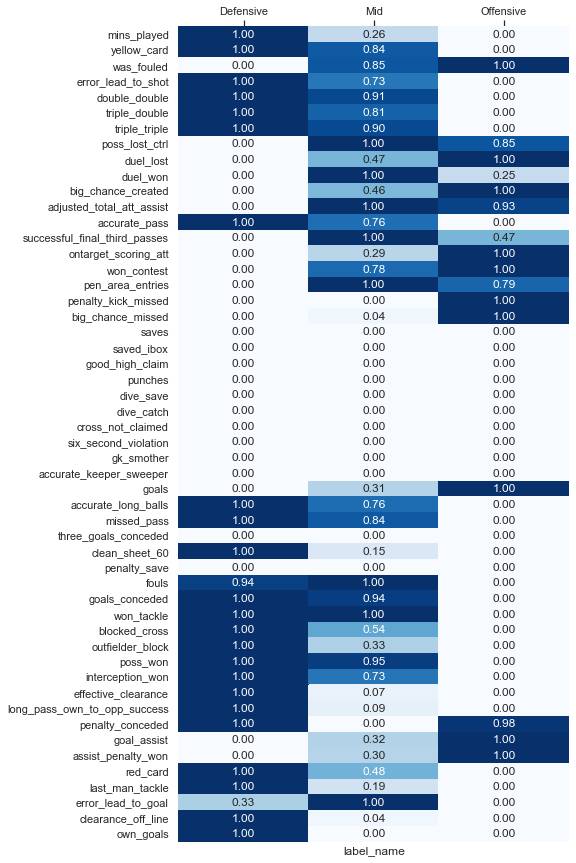

In [325]:
scaler=MinMaxScaler()
cluster_scaled=scaler.fit_transform(cluster_stats)

df_cluster_scaled=pd.DataFrame(data=cluster_scaled,columns=stat_columns,index=cluster_stats.index)

plt.figure(figsize=(7,15))
sns.heatmap(df_cluster_scaled.T,annot=True,cbar=False,fmt='.2f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')


Visualize how each PCA component is included in each cluster

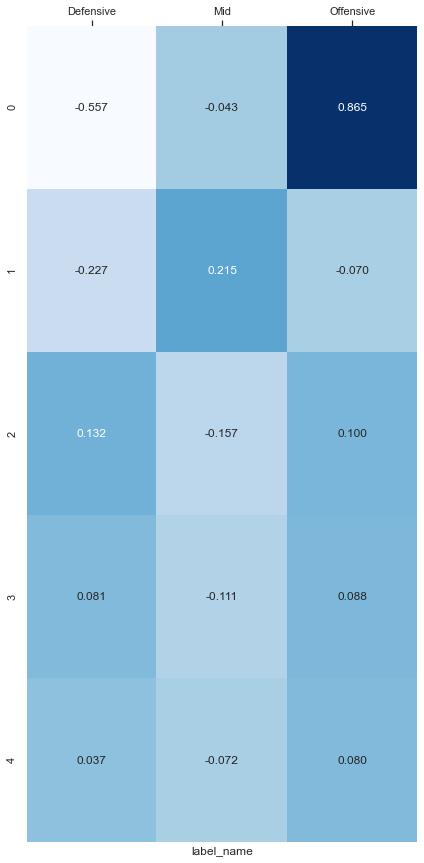

In [326]:
output_pca=df_pca.copy()
output_pca['label_name']=df_output['label_name']
cluster_pca=output_pca.groupby('label_name').mean()

plt.figure(figsize=(7,15))
sns.heatmap(cluster_pca.T,annot=True,cbar=False,fmt='.3f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')

Check how players in best known clubs (Barcelona, Atletico de Madrid and Real Madrid) are being classified.

In [327]:
col_names=['label_name','slug_player','score','position','slug_club','mins_played','dist_midfielder','dist_offensive','dist_defensive']
df_output_dists=df_output[col_names].sort_values(by='label_name')
df_output_dists[df_output_dists.slug_club.isin(['psg-paris','real-madrid-madrid','atletico-madrid-madrid','barcelona-barcelona'])][col_names].sort_values(by='label_name')

,label_name,slug_player,score,position,slug_club,mins_played,dist_midfielder,dist_offensive,dist_defensive
399,Defensive,ronald-federico-araujo-da-silva,34.10,Defender,barcelona-barcelona,63.0,0.879151,1.269478,0.554228
226,Defensive,reinildo-isnard-mandava,42.28,Defender,atletico-madrid-madrid,87.6,0.968336,1.680659,0.471352
235,Defensive,sime-vrsaljko,41.36,Defender,atletico-madrid-madrid,62.2,0.884399,1.514458,0.838800
217,Defensive,jose-maria-gimenez-de-vargas,32.44,Defender,atletico-madrid-madrid,63.0,0.995753,1.215769,0.790889
825,Defensive,marcos-aoas-correa,55.02,Defender,psg-paris,90.0,1.189519,1.582269,0.562137
830,Defensive,presnel-kimpembe,63.34,Defender,psg-paris,87.6,1.148092,1.528707,0.511715
231,Defensive,stefan-savic-1991-01-08,49.86,Defender,atletico-madrid-madrid,90.0,1.535728,2.179173,1.052056
384,Defensive,jordi-alba-ramos,60.92,Defender,barcelona-barcelona,68.4,0.697875,1.444833,0.632978
1021,Defensive,daniel-carvajal-ramos,60.02,Defender,real-madrid-madrid,85.6,0.883431,1.497700,0.609438
1024,Defensive,david-olatukunbo-alaba,47.72,Defender,real-madrid-madrid,72.0,1.043606,1.315306,0.654359


Check players with biggest distance from all clusters. These are the most dis-similar players

In [328]:
df_output_dists['min_dist']=df_output_dists[dist_col_names].apply(min,axis=1)
mask_max=df_output_dists['min_dist']>df_output_dists['min_dist'].quantile(0.95)
df_output_dists[mask_max].sort_values(by='min_dist',ascending=False)

,label_name,slug_player,score,position,slug_club,mins_played,dist_midfielder,dist_offensive,dist_defensive,min_dist
823,Offensive,lionel-andres-messi-cuccittini,82.84,Forward,psg-paris,90.0,2.093873,1.707025,2.500035,1.707025
101,Mid,sofiane-boufal,51.76,Midfielder,angers-sco-angers,85.0,1.263506,1.583535,1.838958,1.263506
963,Mid,franco-emanuel-cervi,64.06,Midfielder,celta-de-vigo-vigo,70.0,1.262992,1.705884,1.615292,1.262992
340,Mid,florian-tardieu,47.78,Midfielder,troyes-troyes,90.0,1.233633,1.980490,1.406674,1.233633
912,Mid,santiago-comesana-veiga,48.52,Midfielder,rayo-vallecano-madrid,86.2,1.230897,2.009704,1.578846,1.230897
683,Mid,jordan-ferri,42.08,Midfielder,montpellier-montpellier,89.8,1.123827,2.009665,1.325381,1.123827
820,Offensive,kylian-mbappe-lottin,75.84,Forward,psg-paris,88.6,1.632697,1.112064,2.066465,1.112064
774,Mid,dimitri-payet,59.08,Midfielder,olympique-marseille-marseille,72.2,1.097159,1.209516,1.544351,1.097159
824,Mid,marco-verratti,54.84,Midfielder,psg-paris,72.0,1.084284,1.743113,1.514631,1.084284
1198,Mid,benjamin-bourigeaud,59.94,Midfielder,rennes-rennes,85.8,1.083472,1.169852,1.419337,1.083472


Using distance to each cluster as a proxy for similarity with a position, we can visualize how each player's playing style resembles the one of defenders, midfielders and forwards. We can also understand which players are more different than everyone else by looking at players with larger distances to cluster centroids. For example Lionel Messi is one of the players most separeted from the rest. This means that his stats are far away from the others.

In [329]:
px.scatter(df_output_dists,
x='dist_defensive',y='dist_offensive',
color='label_name',hover_data=['slug_club','slug_player','mins_played','position','score'],
title='Offensive and defensive similarity')

In [330]:
px.scatter(df_output_dists[df_output_dists.position!='Goalkeeper'],
x='dist_midfielder',y='dist_offensive',
color='label_name',hover_data=['slug_club','slug_player','mins_played','position','score'],
title='Midfielder and offensive similarity')

In [331]:
metric='accurate_pass'
df_player_scores_detailed.sort_values(by=metric,ascending=False)[['slug_club','slug_player','position','score',metric]].head(20)

,slug_club,slug_player,position,score,accurate_pass
824,psg-paris,marco-verratti,Midfielder,54.84,72.4
1050,real-madrid-madrid,toni-kroos,Midfielder,50.70,70.0
731,olympique-lyonnais-lyon,castello-lukeba,Defender,51.14,69.8
760,olympique-lyonnais-lyon,thiago-henrique-mendes-ribeiro,Midfielder,51.68,69.4
871,lens-avion,facundo-axel-medina,Defender,54.36,66.6
830,psg-paris,presnel-kimpembe,Defender,63.34,65.6
397,barcelona-barcelona,gerard-pique-bernabeu,Defender,51.26,65.2
532,nantes-la-chapelle-sur-erdre,pedro-chirivella-burgos,Midfielder,59.80,64.4
825,psg-paris,marcos-aoas-correa,Defender,55.02,63.0
710,nice-nice,dante-bonfim-da-costa-santos,Defender,51.82,62.4


### What makes each player unique?

For each player we look at the stats more different from it's cluster center. These are the aspects in which the player mostly stands out.

In [332]:
df_player_stats_scaled=pd.DataFrame(index=X.index,columns=X.columns,data=X_scaled)
df_player_stats_scaled=df_player_stats_scaled.join(df_output[['slug_club','slug_player','label_name','position','score']],how='left')

In [333]:
def calc_player_vs_cluster(player_slug:str,cluster:str,player_name=None):
    cluster_mean=df_player_stats_scaled[df_player_stats_scaled['label_name']==cluster].mean(numeric_only=True)
    player_mean=df_player_stats_scaled[df_player_stats_scaled['slug_player']==player_slug].mean(numeric_only=True)
    cluster_name=cluster+'_cluster'
    if player_name==None:
        player_name=player_slug
    player_vs_cluster=pd.DataFrame(data={player_name:player_mean,cluster_name:cluster_mean}).reset_index().rename(columns={'index':'stat'})
    player_vs_cluster.head()
    player_vs_cluster['dif']=player_vs_cluster[player_name]-player_vs_cluster[cluster_name]
    player_vs_cluster['abs_dif']=abs(player_vs_cluster['dif'])
    player_vs_cluster.sort_values(by='abs_dif',ascending=False,inplace=True)
    player_vs_cluster.drop(index=player_vs_cluster[player_vs_cluster['stat']=='score'].index,inplace=True)#drop score
    return player_vs_cluster

In [334]:
def plot_player_vs_cluster(player_vs_cluster_df:pd.DataFrame,ax=None):
       player_vs_cluster_df=player_vs_cluster_df.head(10)
       ax.hlines(y=player_vs_cluster_df['stat'], xmin=player_vs_cluster_df[player_vs_cluster_df.columns[2]], xmax=player_vs_cluster_df[player_vs_cluster_df.columns[1]],
           color='#d9d9d9', lw=10)
       sns.scatterplot(data=player_vs_cluster_df,x=player_vs_cluster_df.columns[1],
       y='stat',label=player_vs_cluster_df.columns[1],zorder=3,s=200,color='#0096d7',ax=ax)
       sns.scatterplot(data=player_vs_cluster_df,x=player_vs_cluster_df.columns[2],
       y='stat',label=player_vs_cluster_df.columns[2],zorder=3,s=200,color='#003953',ax=ax);
       
       ax.set_xlabel('')
       ax.set_ylabel('')
       ax.set_xlim(-0.01,1.01)
       ax.set_title(player_vs_cluster_df.columns[1]+'`s Top 10 most different stats',loc='left')
       ax.legend(ncol=2, bbox_to_anchor=(1., -0.2), loc="lower right", frameon=False)



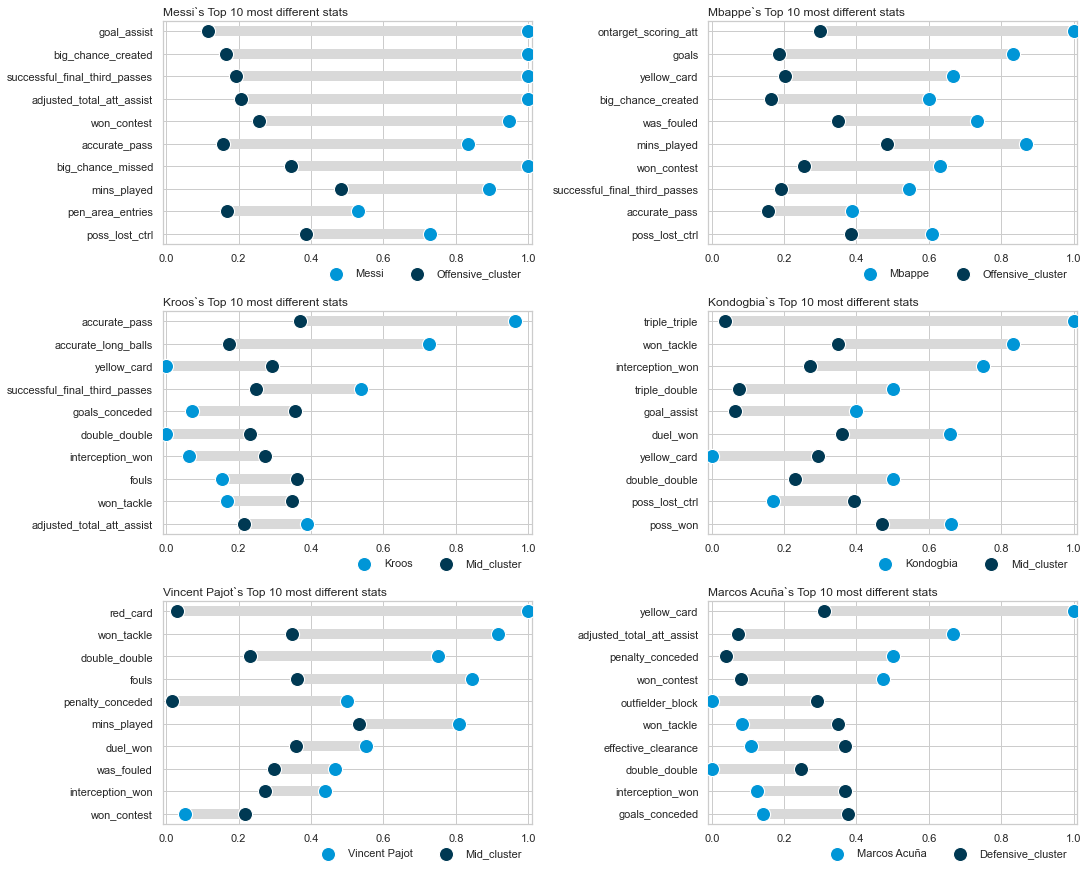

In [335]:

player_names=['Messi','Mbappe','Kroos','Kondogbia','Vincent Pajot','Marcos Acuña']
player_slugs=['lionel-andres-messi-cuccittini','kylian-mbappe-lottin','toni-kroos','geoffrey-kondogbia','vincent-pajot','marcos-javier-acuna']
clusters=['Offensive','Offensive','Mid','Mid','Mid','Defensive']

n_subplots=len(player_names)
cols=2
rows=int(np.ceil(n_subplots/cols))
fig,ax=plt.subplots(rows,cols,figsize=(15,rows*4),constrained_layout=True)

row=0
col=0
for player_slug,player_name,cluster in zip(player_slugs,player_names,clusters):
    player_vs_cluster=calc_player_vs_cluster(player_slug,cluster,player_name)
    ax_i=ax[row,col]
    plot_player_vs_cluster(player_vs_cluster,ax=ax_i)
    col+=1
    if col==cols:
        col=0
        row+=1